In [3]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta

import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-09-27'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df


[*********************100%%**********************]  503 of 503 completed

3 Failed downloads:
['SOLV', 'GEV', 'VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 1443499200, endDate = 1695787200")


Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.483549   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361622   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.651129   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.334900   52.790001   54.189999   51.880001   53.099998   
           ABT      33.478706   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.968483   89.519997   90.849998   89.500000   90.379997   
           YUM     122.811577  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.782722  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.547699  176.869995  178.449997  176.270004  176.580002   

Price                   volume  
date       ticker               
2015-09-29 A         2252400.0  
           AAL       7478800.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
...                        ...  
2023-09-26 XYL       1322400.0  
           YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZTS       1463200.0  

[988898 rows x 6 columns]

In [4]:
# Calculate features and technical indicators per stock
# Garman-Klass Volatility
# RSI
# Bollinger Bands
# ATR
# MACD
# Dollar Volume

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.483549   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361622   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.651129   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.334900   52.790001   54.189999   51.880001   53.099998   
           ABT      33.478706   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.968483   89.519997   90.849998   89.500000   90.379997   
           YUM     122.811577  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.782722  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.547699  176.869995  178.449997  176.270004  176.580002   

Price                   volume    bb_low    bb_mid   bb_high  \
date       ticker                                              
2015-09-29 A         2252400.0       NaN       NaN       NaN   
           AAL       7478800.0       NaN       NaN       NaN   
           AAPL    293461600.0       NaN       NaN       NaN   
           ABBV     12842800.0       NaN       NaN       NaN   
           ABT      12287500.0       NaN       NaN       NaN   
...                        ...       ...       ...       ...   
2023-09-26 XYL       1322400.0  4.488345  4.570270  4.652196   
           YUM       1500600.0  4.816569  4.846536  4.876502   
           ZBH       3610500.0  4.748085  4.787752  4.827420   
           ZBRA       355400.0  5.400991  5.539167  5.677342   
           ZTS       1463200.0  5.156108  5.214922  5.273735   

Price              garman_klass_vol       atr      macd        rsi  \
date       ticker                                                    
2015-09-29 A              -0.000998       NaN       NaN        NaN   
           AAL            -0.000443       NaN       NaN        NaN   
           AAPL           -0.005712       NaN       NaN        NaN   
           ABBV           -0.054655       NaN       NaN        NaN   
           ABT            -0.009402       NaN       NaN        NaN   
...                             ...       ...       ...        ...   
2023-09-26 XYL             0.000016  0.033800 -2.159188  26.146742   
           YUM             0.000002  0.142547 -1.363696  36.057182   
           ZBH             0.000099 -0.381708 -0.881067  31.893258   
           ZBRA            0.000133 -0.057389 -1.600791  29.494977   
           ZTS             0.000062  0.651515 -1.188279  42.623467   

Price              dollar_volume  
date       ticker                 
2015-09-29 A           70.913546  
           AAL        279.420098  
           AAPL      7234.159690  
           ABBV       466.641852  
           ABT        411.369604  
...                          ...  
2023-09-26 XYL        117.651922  
           YUM        184.291052  
           ZBH        403.591519  
           ZBRA        79.595386  
           ZTS        256.861393  

[988898 rows x 14 columns]

In [5]:
# Filter top 150 most liquid stocks for each month

last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data


dollar_volume   adj close    bb_low    bb_mid   bb_high  \
date       ticker                                                            
2015-11-30 A          135.992821   39.023201  3.545991  3.618440  3.690888   
           AAL        287.915793   39.429935  3.672028  3.749832  3.827636   
           AAPL      4023.983823   26.854130  3.281679  3.324990  3.368302   
           ABBV       337.563918   40.393524  3.726695  3.774943  3.823191   
           ABT        211.659061   38.293575  3.656056  3.677909  3.699763   
...                          ...         ...       ...       ...       ...   
2023-09-30 OTIS       154.983159   78.671936  4.374104  4.419394  4.464683   
           ABNB      1633.500725  132.279999  4.857047  4.940924  5.024801   
           CEG        196.971017  108.026909  4.653660  4.693834  4.734007   
           GEHC       212.275851   66.130219  4.155436  4.212972  4.270508   
           KVUE       670.804280   20.006195  3.014275  3.089221  3.164168   

                   garman_klass_vol       atr      macd        rsi  
date       ticker                                                   
2015-11-30 A              -0.001992 -1.033887  0.567158  73.421622  
           AAL            -0.000966  0.190822 -0.418771  40.718964  
           AAPL           -0.003307 -0.967900 -0.142790  55.537261  
           ABBV           -0.059549 -0.526809  0.145677  49.376843  
           ABT            -0.011216 -1.064842  0.335558  56.962608  
...                             ...       ...       ...        ...  
2023-09-30 OTIS           -0.000020 -1.028320 -1.534536  33.116247  
           ABNB            0.000213 -1.006939 -0.037854  44.494127  
           CEG             0.000171 -0.436215  0.366876  55.245465  
           GEHC            0.000185 -0.893478 -1.116463  40.922335  
           KVUE           -0.000159 -0.899746 -1.435620  35.706324  

[46692 rows x 9 columns]

In [6]:
# Calulate the 5 year rolling average dollar volume for each stock 

data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close    bb_low    bb_mid   bb_high  garman_klass_vol  \
date       ticker                                                               
2016-10-31 AAL      39.134327  3.604673  3.655494  3.706314         -0.000176   
           AAPL     26.212469  3.294237  3.323117  3.351997         -0.002468   
           ABBV     40.245125  3.753446  3.807610  3.861774         -0.046691   
           ABT      34.293453  3.554632  3.605106  3.655580         -0.007492   
           ACN     103.569633  4.637342  4.648980  4.660617         -0.004643   
...                       ...       ...       ...       ...               ...   
2023-09-30 WMT      53.783062  3.988367  4.005838  4.023309         -0.000011   
           XOM     113.372101  4.687091  4.727187  4.767283         -0.000065   
           MRNA     98.120003  4.582514  4.685332  4.788149          0.000146   
           UBER     44.270000  3.806654  3.862227  3.917801          0.000441   
           ABNB    132.279999  4.857047  4.940924  5.024801          0.000213   

                        atr      macd        rsi  
date       ticker                                 
2016-10-31 AAL     0.402199  1.131596  62.203532  
           AAPL   -1.038688 -0.195978  49.891011  
           ABBV   -0.893132 -0.760593  27.477665  
           ABT    -1.035224 -0.650888  38.008841  
           ACN    -0.996806 -0.135456  53.823712  
...                     ...       ...        ...  
2023-09-30 WMT    -0.196381  0.399459  54.722557  
           XOM     0.601335  1.400624  59.440185  
           MRNA   -0.529511 -0.376899  38.747314  
           UBER   -0.746098 -0.133973  45.005268  
           ABNB   -1.006939 -0.037854  44.494127  

[12516 rows x 8 columns]

In [7]:
# Calculate monthly returns for different horizon as features

# Use lags for 1, 2, 3, 6, 9, 12 months gives 6 different lags

def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close    bb_low    bb_mid   bb_high  garman_klass_vol  \
date       ticker                                                               
2017-10-31 AAL      45.534168  3.849110  3.921750  3.994389         -0.000363   
           AAPL     39.713902  3.594730  3.641603  3.688475         -0.001055   
           ABBV     67.491150  4.196702  4.243063  4.289423         -0.034008   
           ABT      48.493385  3.892568  3.916137  3.939707         -0.005190   
           ACN     129.399719  4.802675  4.842354  4.882034         -0.003925   
...                       ...       ...       ...       ...               ...   
2023-09-30 WMT      53.783062  3.988367  4.005838  4.023309         -0.000011   
           XOM     113.372101  4.687091  4.727187  4.767283         -0.000065   
           MRNA     98.120003  4.582514  4.685332  4.788149          0.000146   
           UBER     44.270000  3.806654  3.862227  3.917801          0.000441   
           ABNB    132.279999  4.857047  4.940924  5.024801          0.000213   

                        atr      macd        rsi  return_1m  return_2m  \
date       ticker                                                        
2017-10-31 AAL     1.011062 -0.018697  41.051776  -0.014108   0.022981   
           AAPL   -0.906642 -0.039275  69.196797   0.096808   0.015250   
           ABBV    0.375557  0.473815  55.247890   0.022728   0.098590   
           ABT    -1.040044  0.276133  53.844986   0.021276   0.034308   
           ACN    -0.986514  0.352342  69.365433   0.064180   0.048455   
...                     ...       ...        ...        ...        ...   
2023-09-30 WMT    -0.196381  0.399459  54.722557  -0.000676   0.010014   
           XOM     0.601335  1.400624  59.440185   0.046947   0.046139   
           MRNA   -0.529511 -0.376899  38.747314  -0.132219  -0.086803   
           UBER   -0.746098 -0.133973  45.005268  -0.062672  -0.053920   
           ABNB   -1.006939 -0.037854  44.494127   0.005549  -0.067704   

                   return_3m  return_6m  return_9m  return_12m  
date       ticker                                               
2017-10-31 AAL     -0.023860   0.016495   0.007008    0.012702  
           AAPL     0.044955   0.028875   0.038941    0.035228  
           ABBV     0.091379   0.056495   0.047273    0.044026  
           ABT      0.034801   0.038672   0.031320    0.029294  
           ACN      0.037203   0.028692   0.027398    0.018728  
...                      ...        ...        ...         ...  
2023-09-30 WMT      0.012354   0.017574   0.016553    0.020256  
           XOM      0.030496   0.012838   0.008747    0.027037  
           MRNA    -0.068763  -0.071952  -0.064976   -0.015431  
           UBER     0.008422   0.057244   0.066838    0.043691  
           ABNB     0.010603   0.010289   0.049124    0.019401  

[10346 rows x 14 columns]

In [8]:
# Download Fama-French factors and calculate rolling factor betas

factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data


Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096808
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021276
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.009617
           VZ     -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.056890
           WFC    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.015500
           WMT    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.000676
           XOM    -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.046947

[10346 rows x 6 columns]

In [9]:
# Filtering out stocks with less than 10 months of data, as will break our model

observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data



Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096808
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021276
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.009617
           VZ     -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.056890
           WFC    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.015500
           WMT    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.000676
           XOM    -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.046947

[10317 rows x 6 columns]

In [10]:
# Now calculate rolling factor betas

betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VRTX    0.456426 -0.445902 -0.312668 -0.079430  0.800286
           VZ      0.332655 -0.165644  0.267343  0.310367  0.106902
           WFC     1.121745  0.300521  2.061531 -0.439487 -1.517556
           WMT     0.700557 -0.315602 -0.413432 -0.142905  0.508470
           XOM     0.983510 -1.093760  1.756776 -0.640866 -0.368455

[10317 rows x 5 columns]

In [11]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

desired_columns = ['atr', 'bb_high', 'bb_low', 'bb_mid', 'garman_klass_vol', 'macd', 'rsi', 'return_1m', 'return_2m', 'return_3m', 'return_6m', 'return_9m', 'return_12m', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

# Ensure the DataFrame has the correct column order
data = data.reindex(columns=desired_columns)

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10136 entries, (Timestamp('2017-10-31 00:00:00'), 'AAL') to (Timestamp('2023-09-30 00:00:00'), 'UBER')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10136 non-null  float64
 1   bb_high           10136 non-null  float64
 2   bb_low            10136 non-null  float64
 3   bb_mid            10136 non-null  float64
 4   garman_klass_vol  10136 non-null  float64
 5   macd              10136 non-null  float64
 6   rsi               10136 non-null  float64
 7   return_1m         10136 non-null  float64
 8   return_2m         10136 non-null  float64
 9   return_3m         10136 non-null  float64
 10  return_6m         10136 non-null  float64
 11  return_9m         10136 non-null  float64
 12  return_12m        10136 non-null  float64
 13  Mkt-RF            10136 non-null  float64
 14  SMB               10136 non-null  float64
 15  HML       

In [19]:
# Fitting a KMeans clutstering algorithim for each month, will split stocks into four clusters

from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)

target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2017-10-31 AAL     1.011062  3.994389  3.849110  3.921750         -0.000363   
           AAPL   -0.906642  3.688475  3.594730  3.641603         -0.001055   
           ABBV    0.375557  4.289423  4.196702  4.243063         -0.034008   
           ABT    -1.040044  3.939707  3.892568  3.916137         -0.005190   
           ACN    -0.986514  4.882034  4.802675  4.842354         -0.003925   
...                     ...       ...       ...       ...               ...   
2023-09-30 WFC    -0.558742  3.783384  3.702645  3.743015          0.000016   
           WMT    -0.196381  4.023309  3.988367  4.005838         -0.000011   
           XOM     0.601335  4.767283  4.687091  4.727187         -0.000065   
           MRNA   -0.529511  4.788149  4.582514  4.685332          0.000146   
           UBER   -0.746098  3.917801  3.806654  3.862227          0.000441   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2017-10-31 AAL    -0.018697  41.051776  -0.014108   0.022981  -0.023860   
           AAPL   -0.039275  69.196797   0.096808   0.015250   0.044955   
           ABBV    0.473815  55.247890   0.022728   0.098590   0.091379   
           ABT     0.276133  53.844986   0.021276   0.034308   0.034801   
           ACN     0.352342  69.365433   0.064180   0.048455   0.037203   
...                     ...        ...        ...        ...        ...   
2023-09-30 WFC    -0.282325  40.920277  -0.015500  -0.057917  -0.013554   
           WMT     0.399459  54.722557  -0.000676   0.010014   0.012354   
           XOM     1.400624  59.440185   0.046947   0.046139   0.030496   
           MRNA   -0.376899  38.747314  -0.132219  -0.086803  -0.068763   
           UBER   -0.133973  45.005268  -0.062672  -0.053920   0.008422   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-10-31 AAL      0.016495   0.007008    0.012702  1.265664  1.314316   
           AAPL     0.028875   0.038941    0.035228  1.275749 -0.271694   
           ABBV     0.056495   0.047273    0.044026  0.494522  0.362281   
           ABT      0.038672   0.031320    0.029294  0.828091 -0.199019   
           ACN      0.028692   0.027398    0.018728  1.199048 -0.166701   
...                      ...        ...         ...       ...       ...   
2023-09-30 WFC      0.016712   0.000702    0.003255  1.137639  0.314482   
           WMT      0.017574   0.016553    0.020256  0.740055 -0.261891   
           XOM      0.012838   0.008747    0.027037  1.005967 -1.051371   
           MRNA    -0.071952  -0.064976   -0.015431  1.155154  0.762525   
           UBER     0.057244   0.066838    0.043691  1.078922  1.162540   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-10-31 AAL     0.601340  0.458860  0.563294        1  
           AAPL   -0.591145  0.647782  0.458079        3  
           ABBV   -0.033102  0.241980  0.164920        2  
           ABT    -0.529385  0.252406  0.970213        2  
           ACN    -0.328213  0.267787  0.168882        3  
...                     ...       ...       ...      ...  
2023-09-30 WFC     2.009072 -0.404336 -1.468838        1  
           WMT    -0.522676 -0.126425  0.642626        3  
           XOM     1.707834 -0.675678 -0.284025        3  
           MRNA   -1.165677  0.590306  0.993548        1  
           UBER   -0.257003 -1.482231 -0.450323        2  

[10136 rows x 19 columns]

In [20]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return


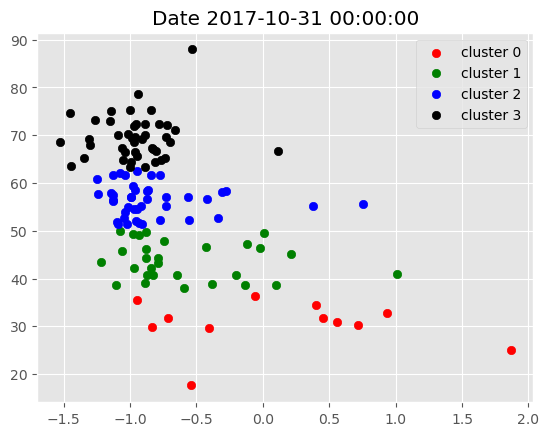

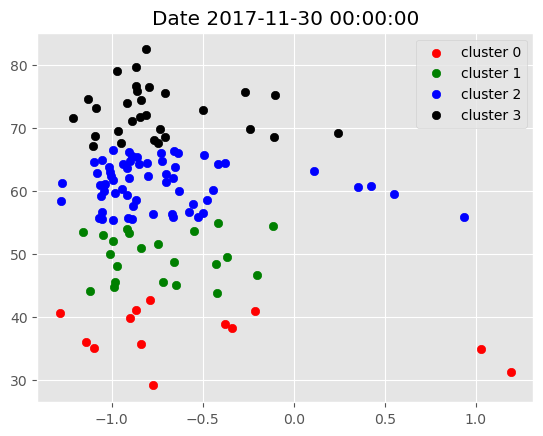

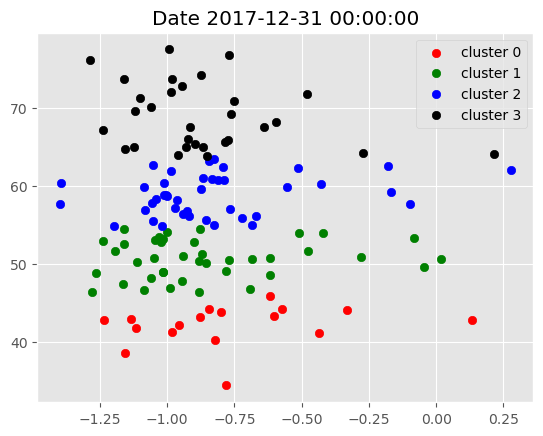

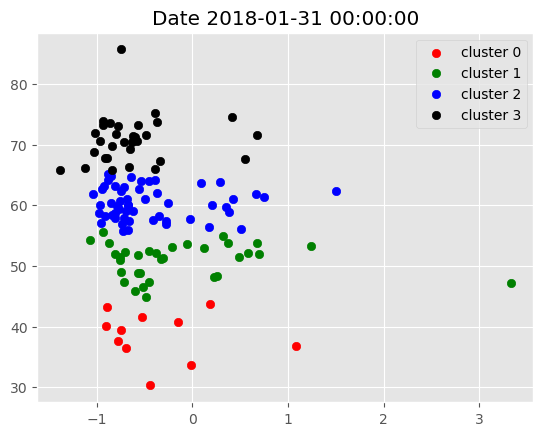

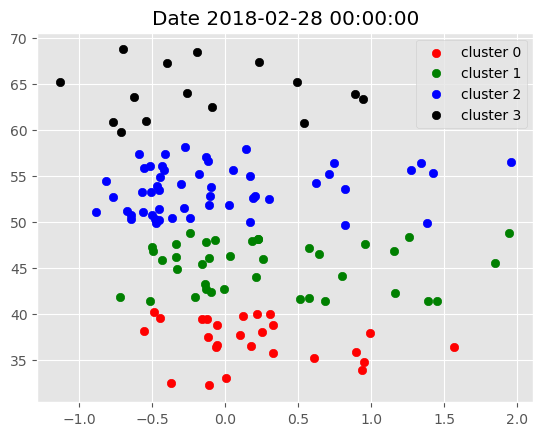

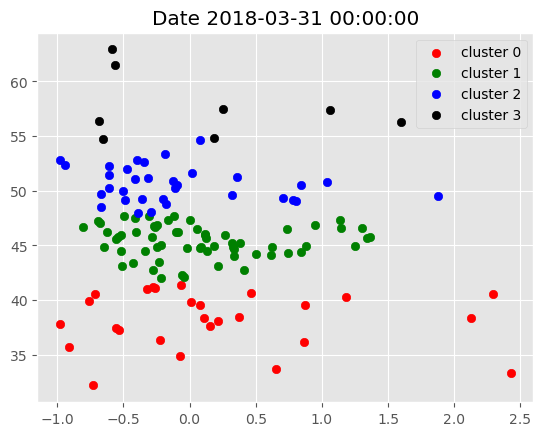

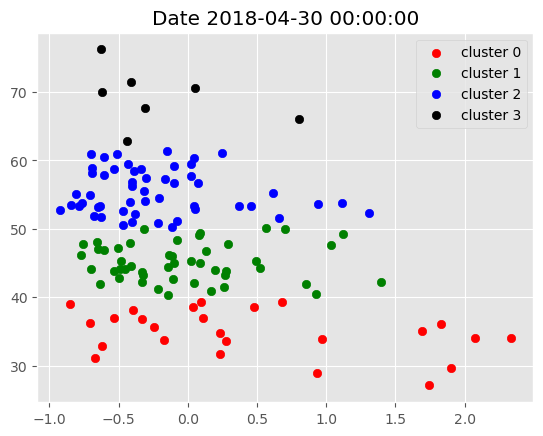

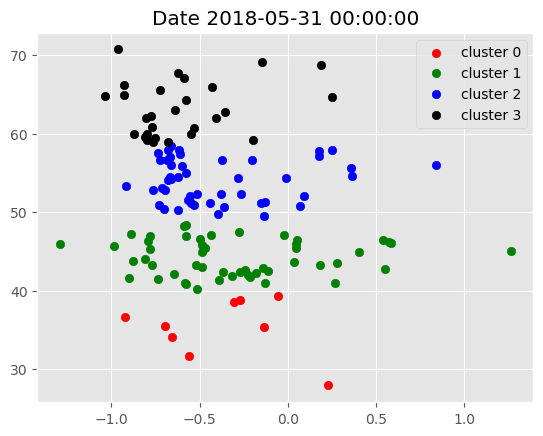

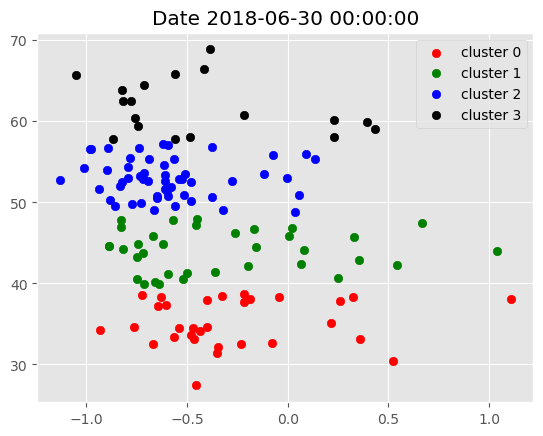

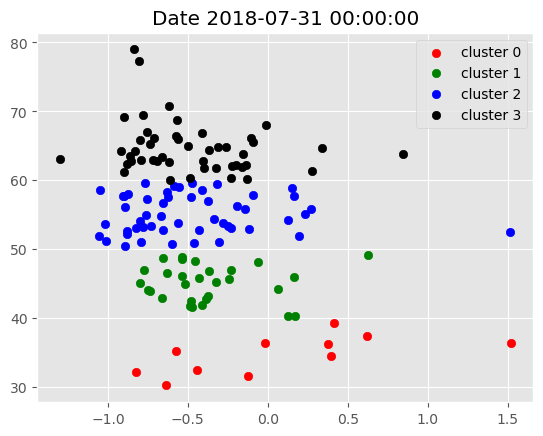

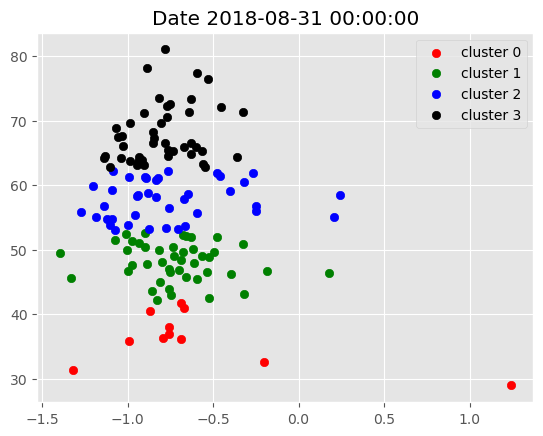

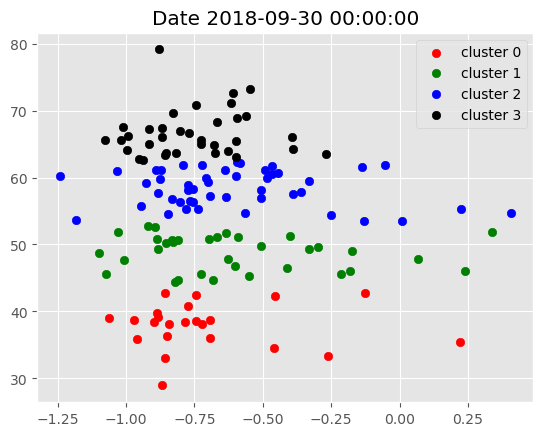

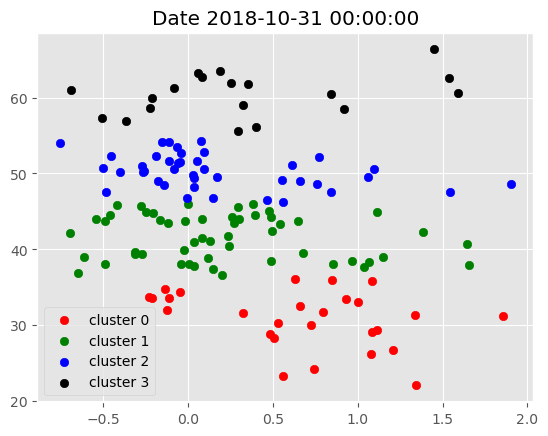

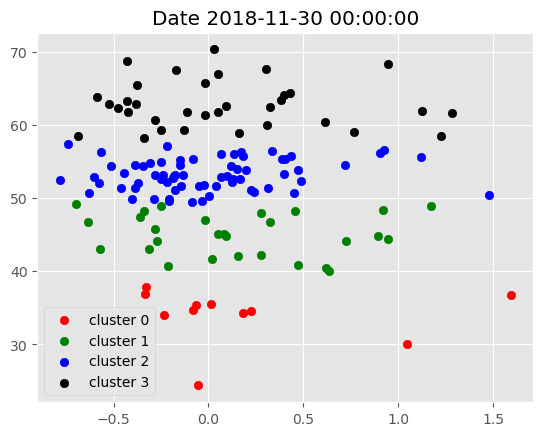

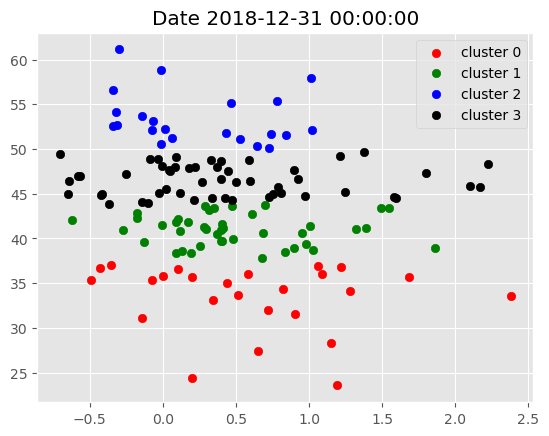

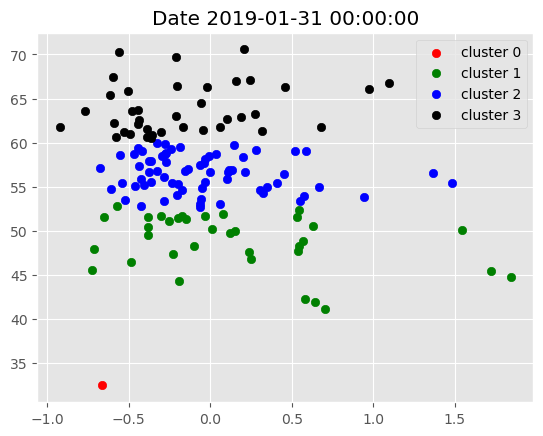

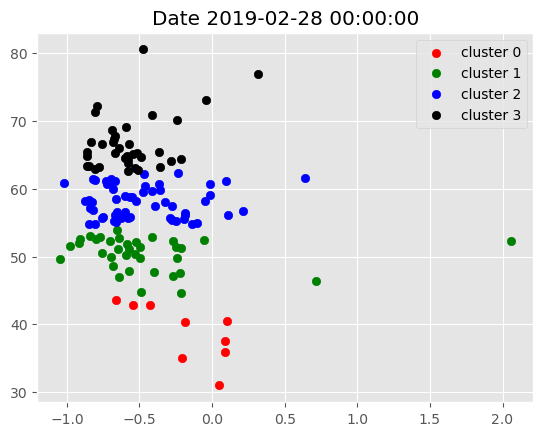

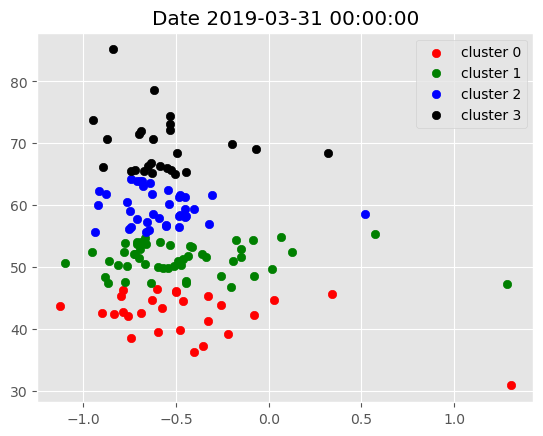

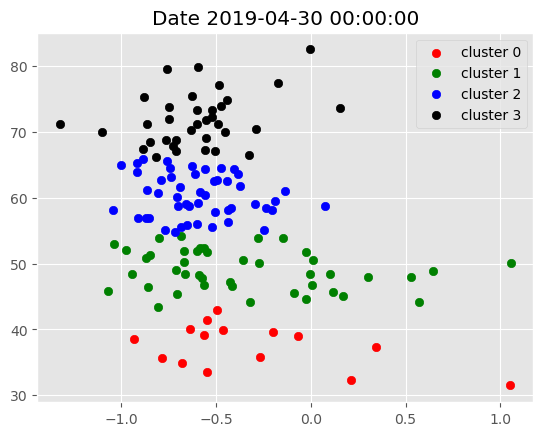

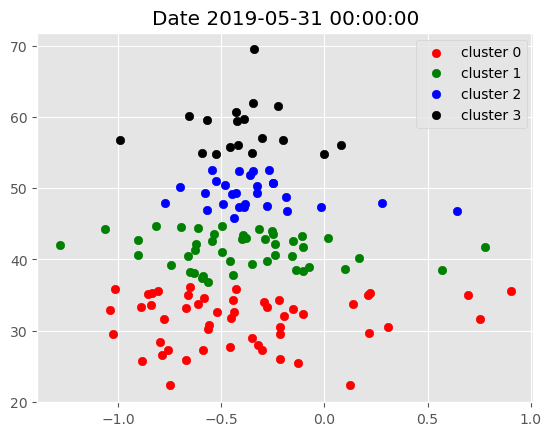

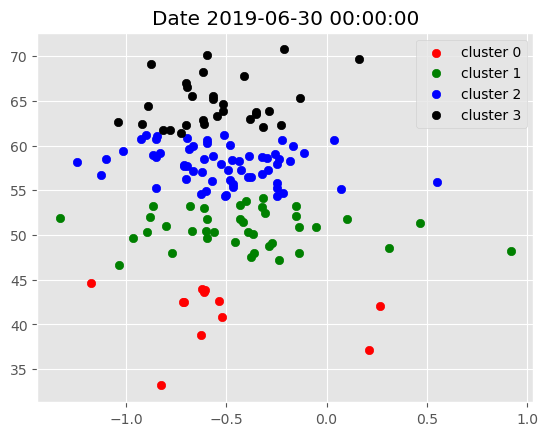

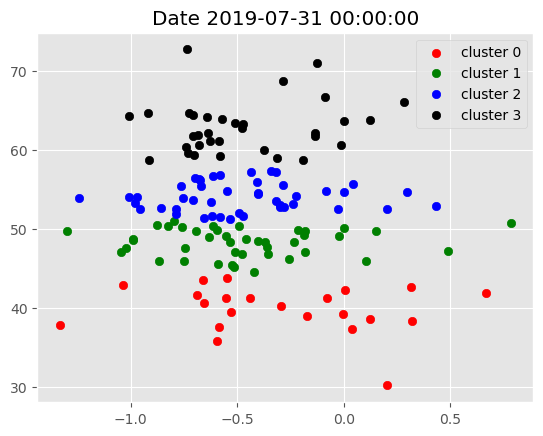

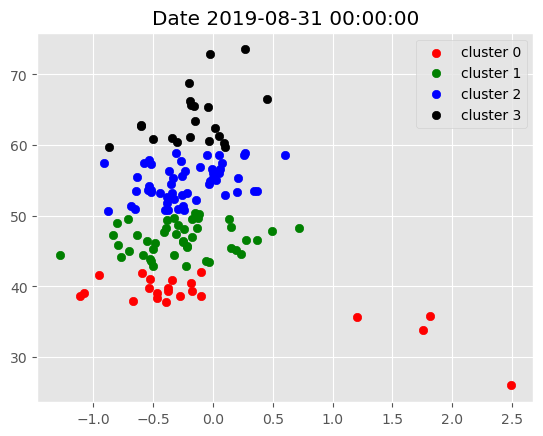

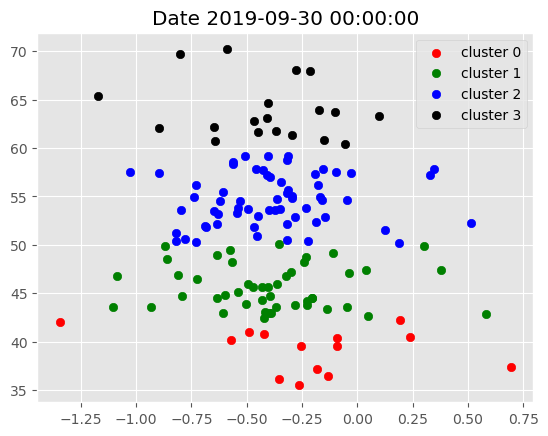

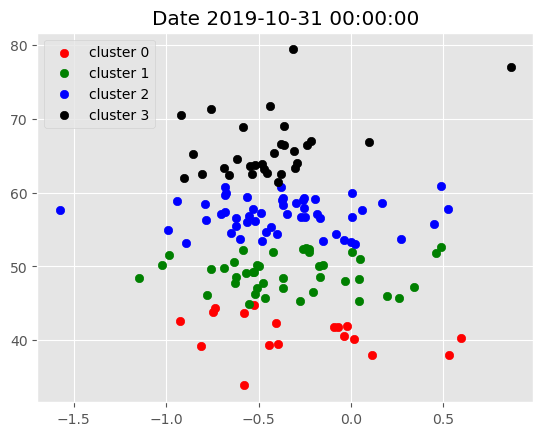

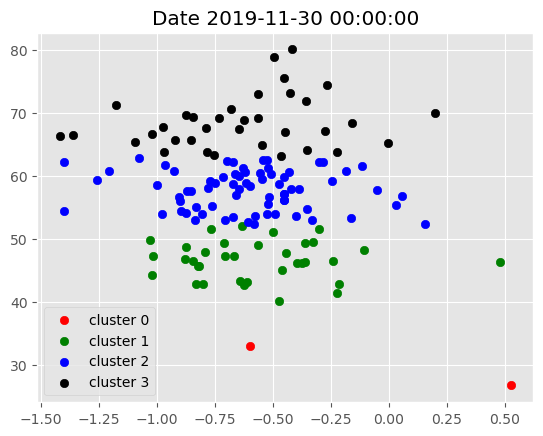

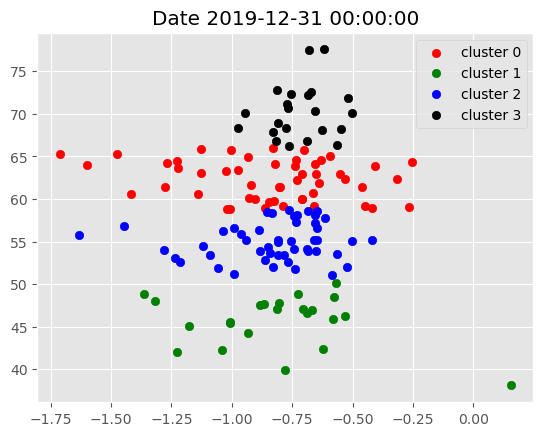

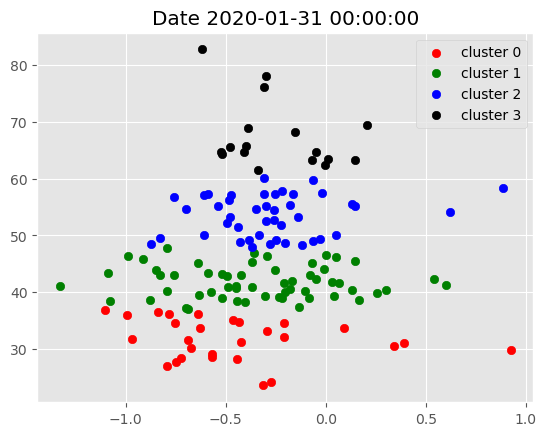

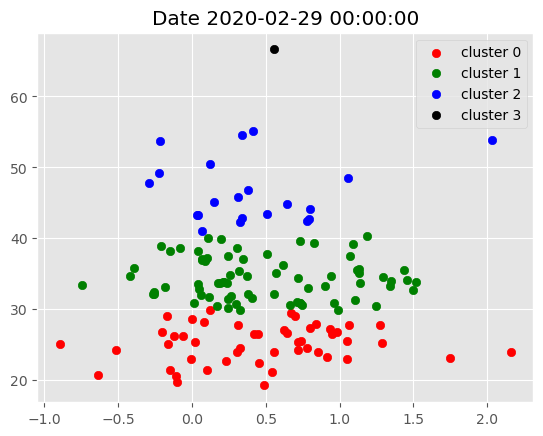

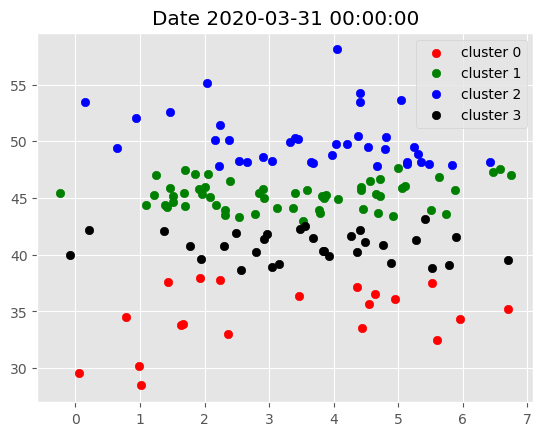

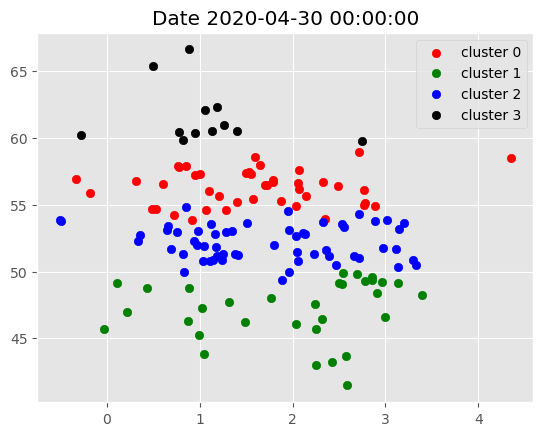

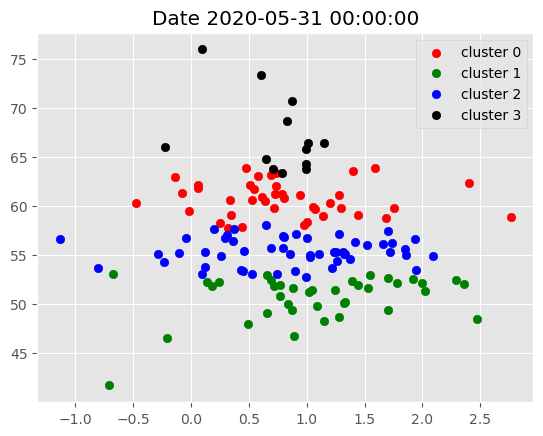

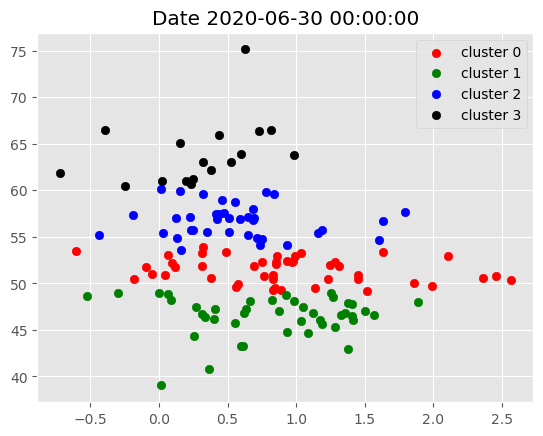

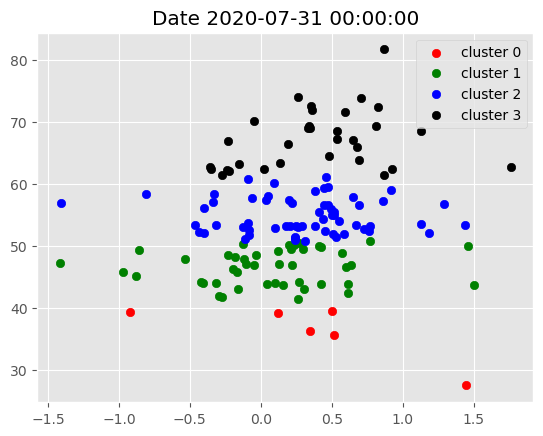

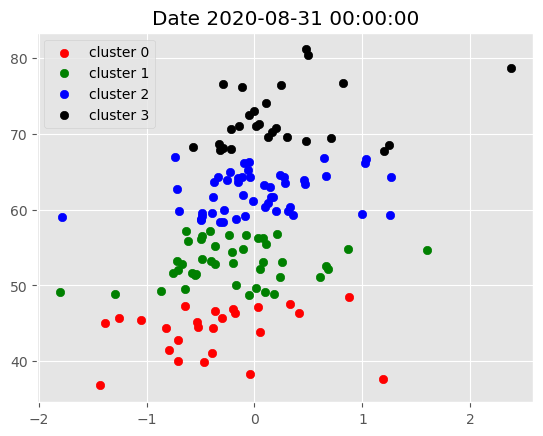

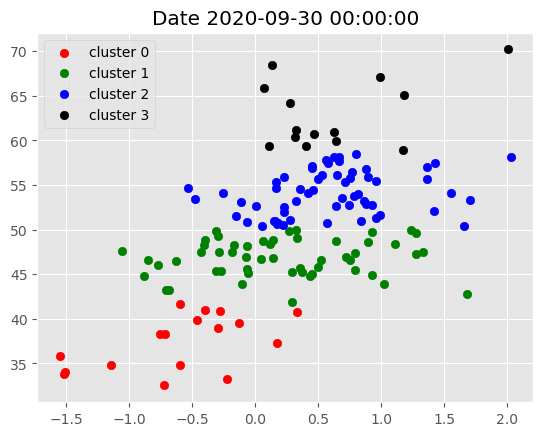

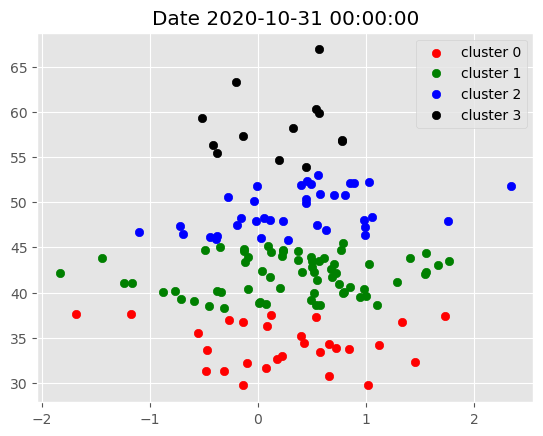

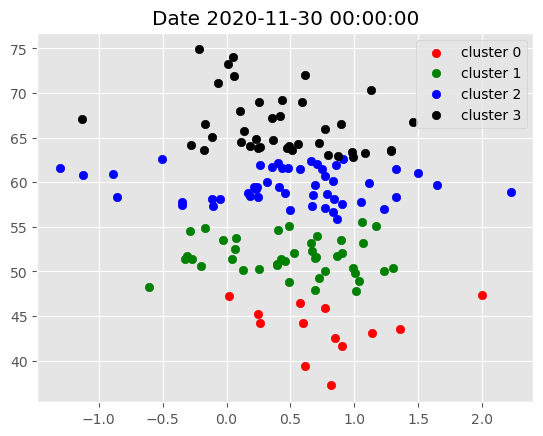

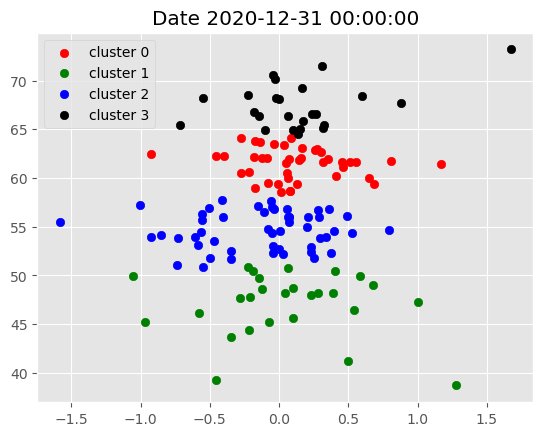

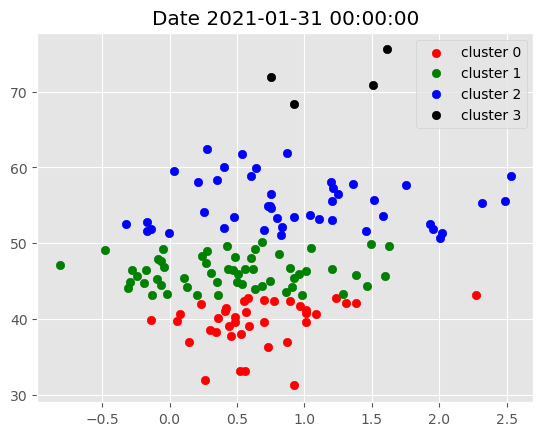

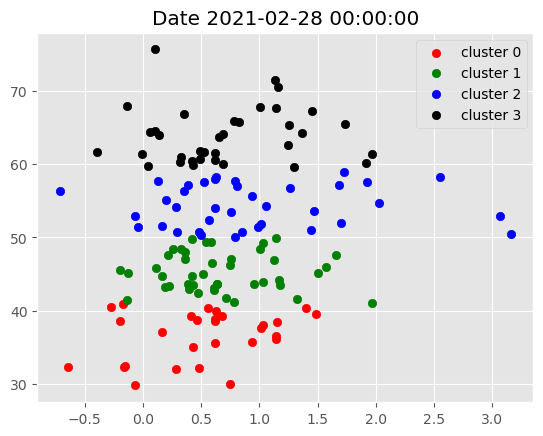

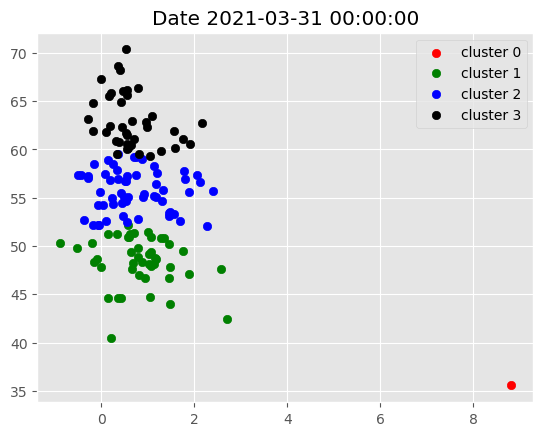

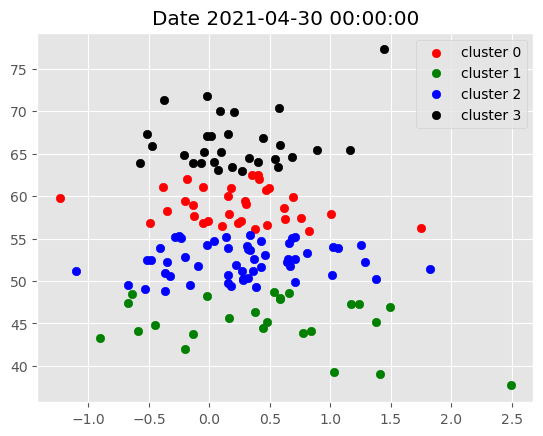

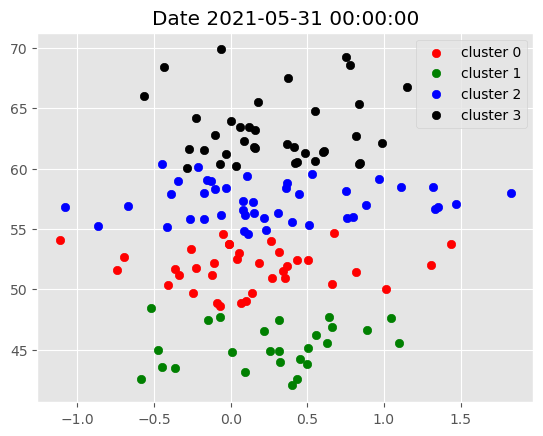

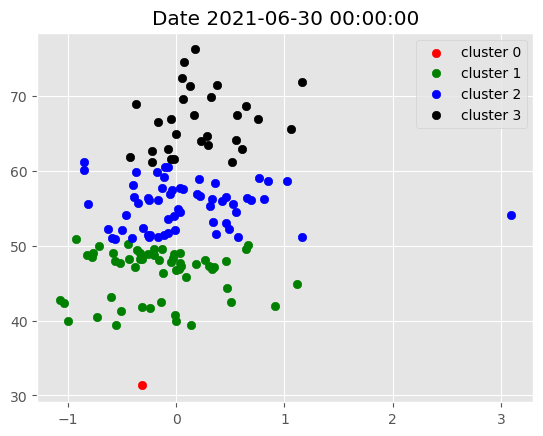

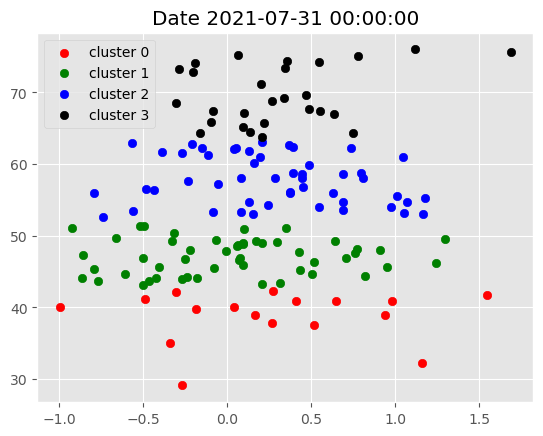

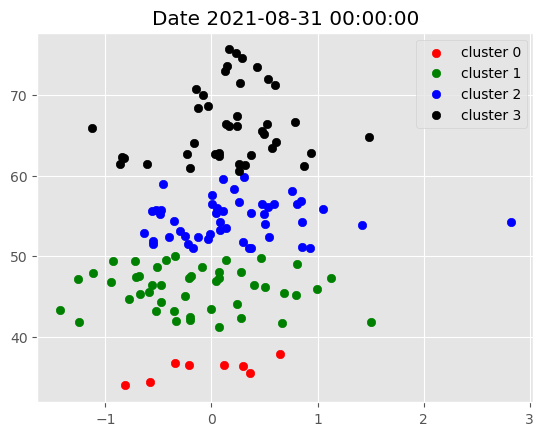

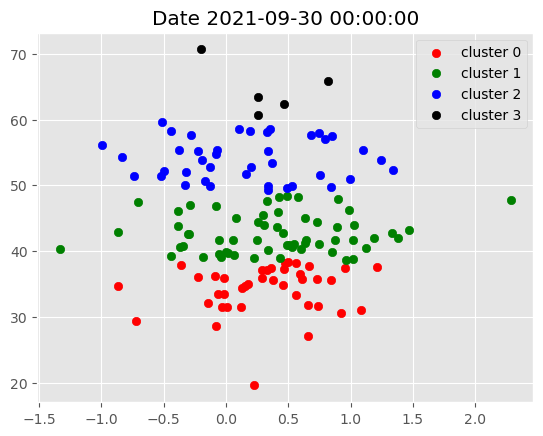

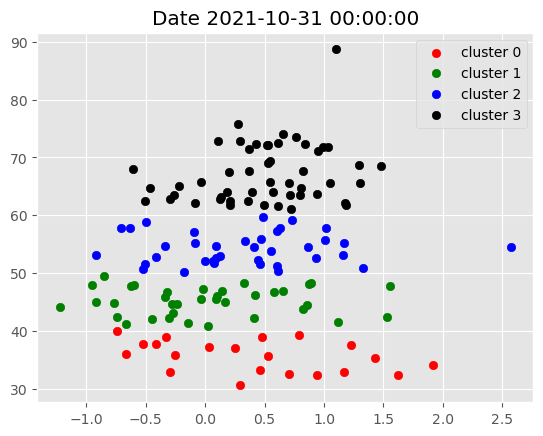

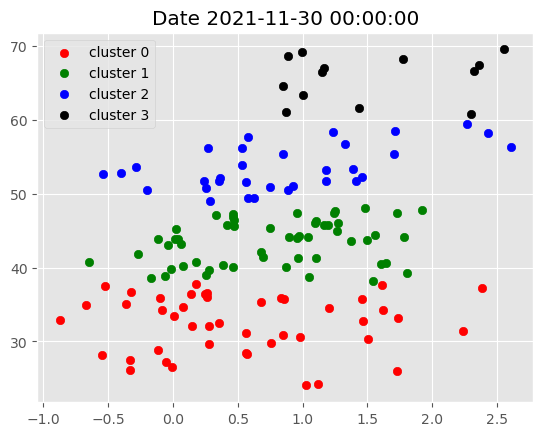

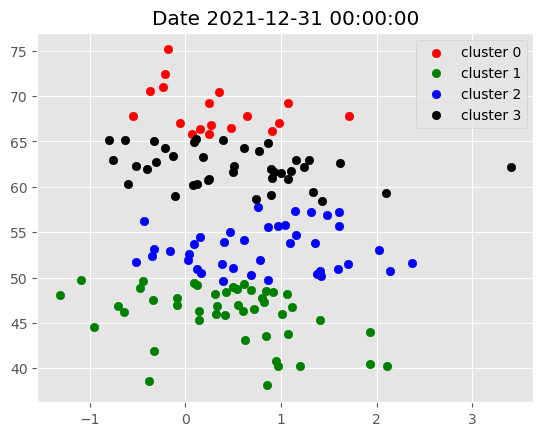

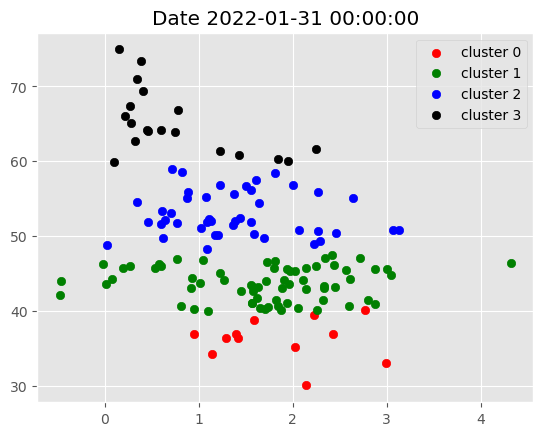

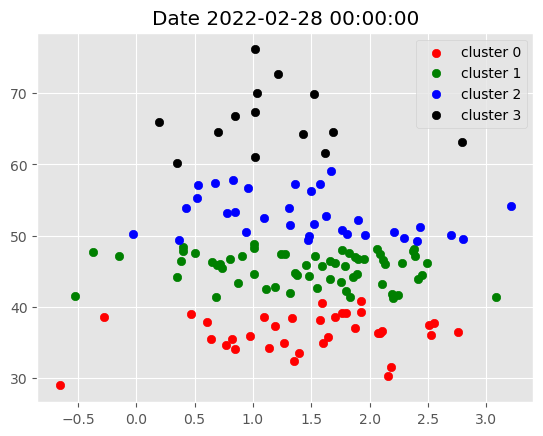

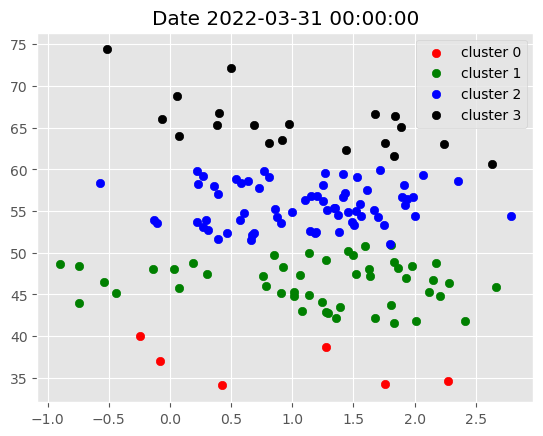

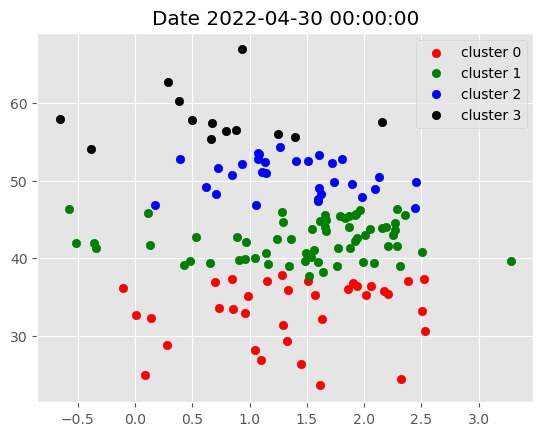

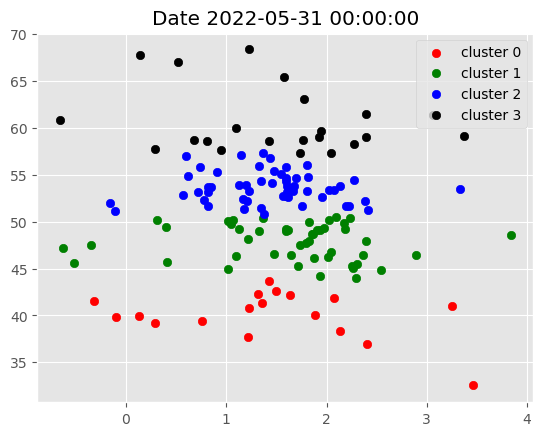

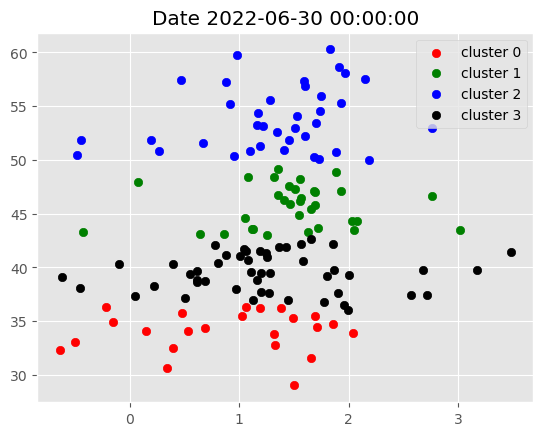

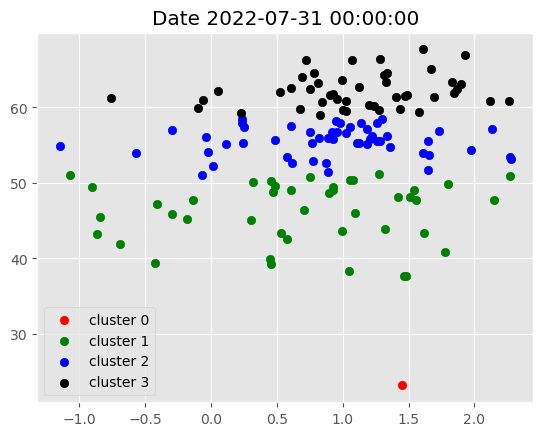

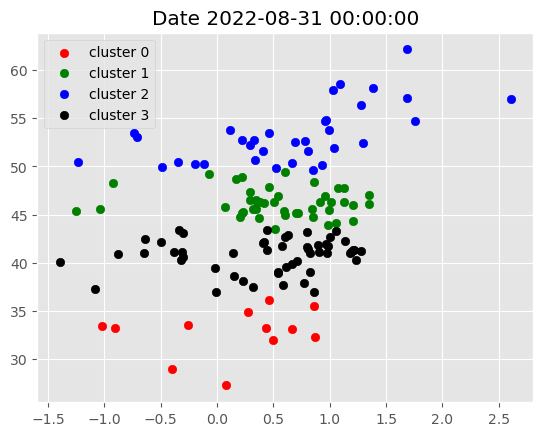

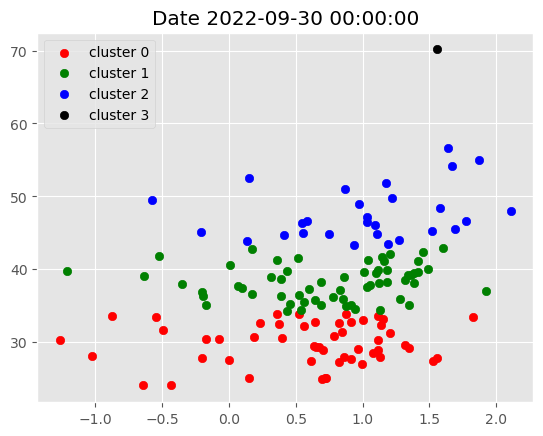

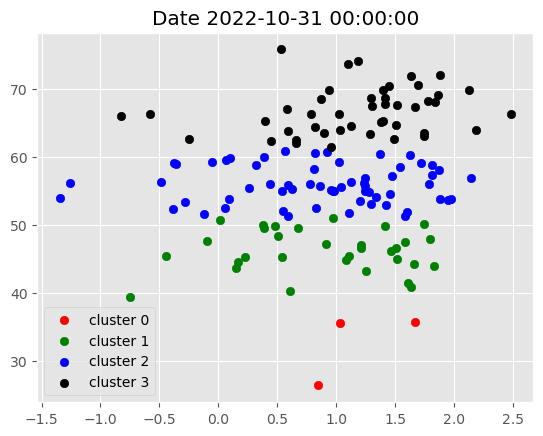

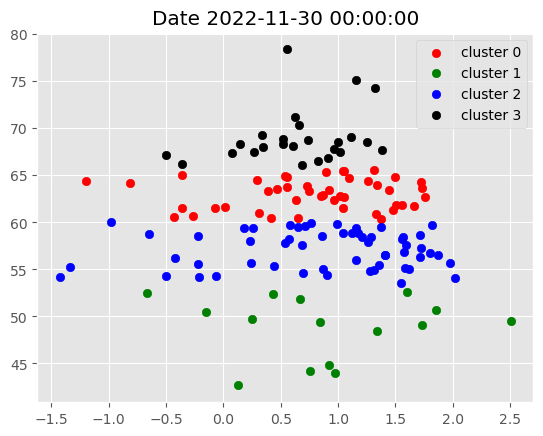

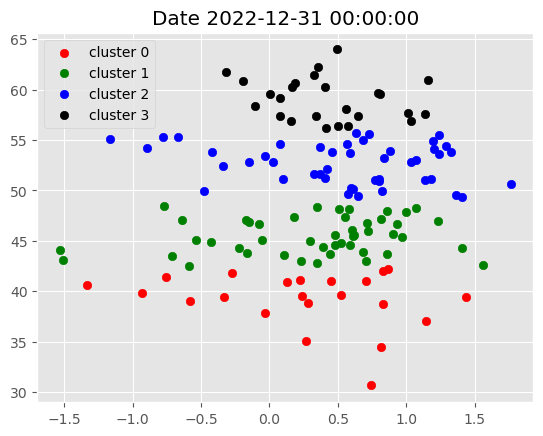

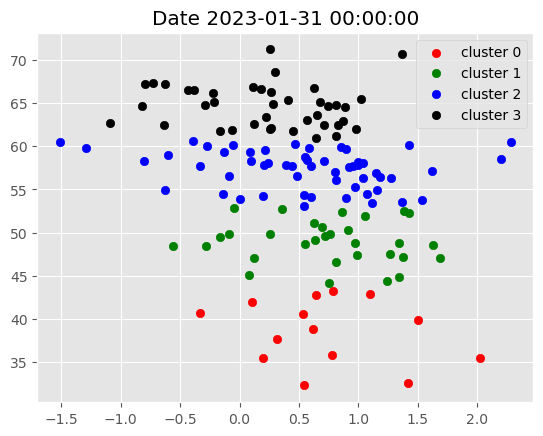

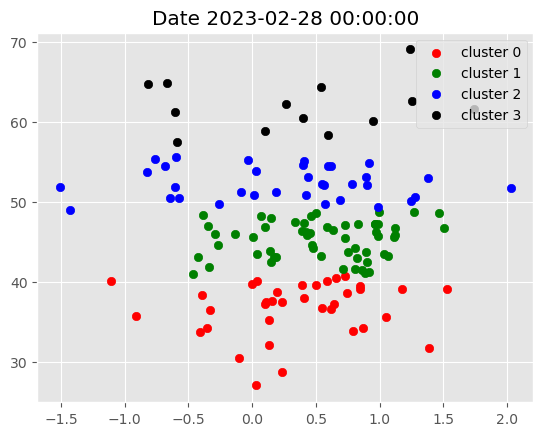

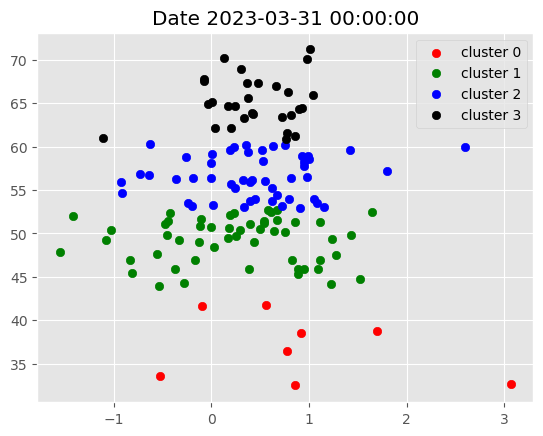

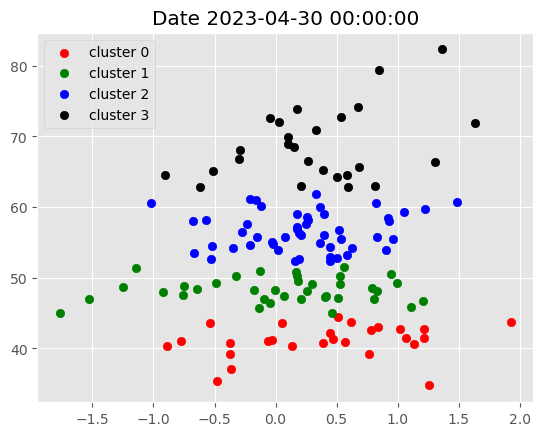

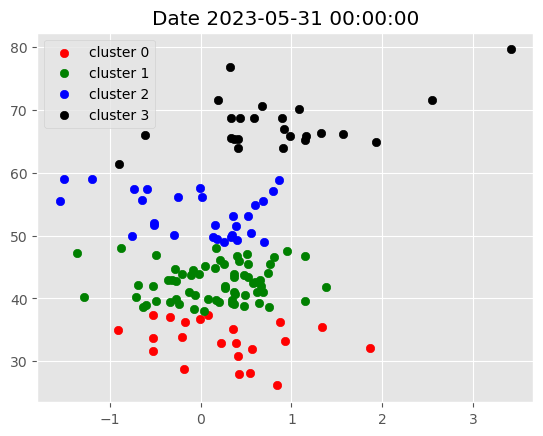

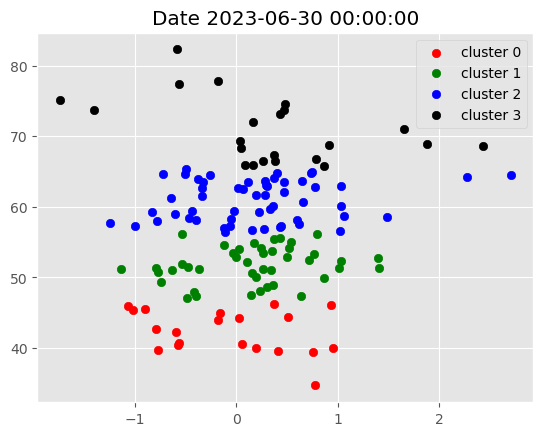

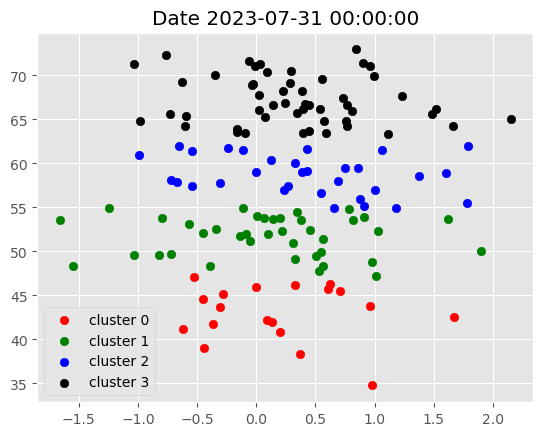

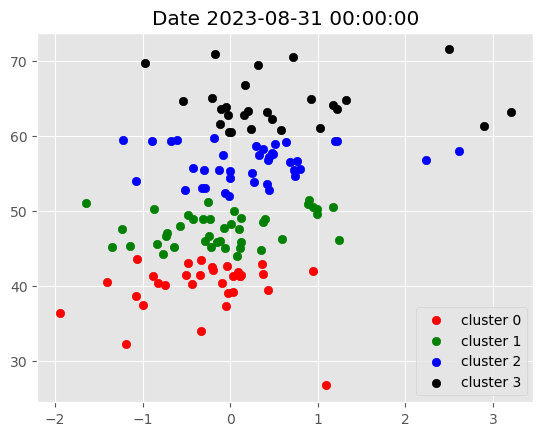

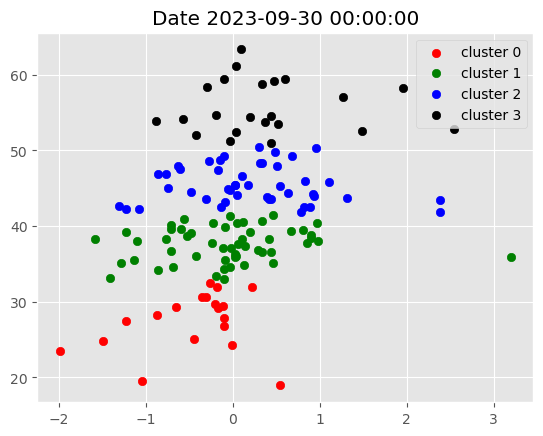

In [21]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

In [34]:
# Select stocks based on clustering and form a portfolio

filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2017-11-01': ['AAPL',
  'ACN',
  'ADBE',
  'AMAT',
  'AMZN',
  'AVGO',
  'AXP',
  'BAC',
  'CAT',
  'COP',
  'CRM',
  'CTSH',
  'DE',
  'DHR',
  'DLTR',
  'ELV',
  'EOG',
  'GOOG',
  'GOOGL',
  'INTC',
  'ISRG',
  'JPM',
  'MA',
  'MAR',
  'MCD',
  'MET',
  'META',
  'MMM',
  'MSFT',
  'MU',
  'NEE',
  'NVDA',
  'NXPI',
  'ORCL',
  'PYPL',
  'SHW',
  'STZ',
  'TXN',
  'UNH',
  'V',
  'VLO',
  'WMT',
  'XOM'],
 '2017-12-01': ['AMZN',
  'AXP',
  'AZO',
  'BA',
  'BAC',
  'BRK-B',
  'CAT',
  'COST',
  'CSCO',
  'DE',
  'DLTR',
  'ELV',
  'HD',
  'HON',
  'ILMN',
  'JPM',
  'KR',
  'LUV',
  'MAR',
  'MMM',
  'NKE',
  'ORLY',
  'OXY',
  'SCHW',
  'UNH',
  'UNP',
  'VLO',
  'VZ',
  'WMT'],
 '2018-01-01': ['ACN',
  'BA',
  'BAC',
  'CAT',
  'CSCO',
  'CVX',
  'DAL',
  'DE',
  'DG',
  'EOG',
  'FCX',
  'FDX',
  'HAL',
  'HD',
  'KR',
  'LOW',
  'LUV',
  'MAR',
  'OXY',
  'PEP',
  'RTX',
  'STZ',
  'T',
  'TXN',
  'UAL',
  'UNP',
  'VLO',
  'VZ',
  'WMT',
  'WYNN'],
 '2018-02-01': ['ABT',
  '